# Project: Image Classification and Regression

## 2.Download the code


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import np_utils

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [7]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

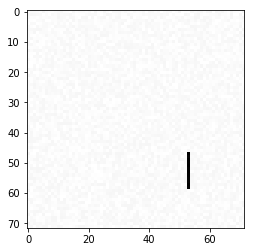

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

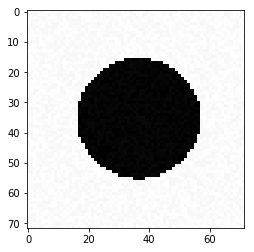

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

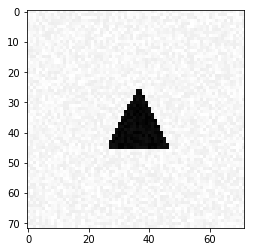

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [13]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [14]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [15]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3.Simple classification

### 3.1 SGD optimization

In [18]:
#generate train set
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3)

#build models
from keras.models import Sequential

model1=Sequential()

#Defining the Network
from keras.layers import Dense, Activation

nb_nerons =  128
model1.add(Dense(nb_nerons, input_shape=(X_train.shape[1],)))
model1.add(Activation('relu'))
model1.add(Dense(3,activation='softmax'))

#defining the optimization method
#stochastic gradient descent optimizer
from keras.optimizers import SGD

sgd=SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)

model1.compile(loss='mean_squared_error',optimizer=sgd)

model1.fit(X_train,Y_train,epochs=10,batch_size=30)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/10
300/300 [==============================] - 0s 2ms/step - loss: 0.3025
Epoch 2/10
300/300 [==============================] - 0s 620us/step - loss: 0.2319
Epoch 3/10
300/300 [==============================] - 0s 565us/step - loss: 0.2080
Epoch 4/10
300/300 [==============================] - 0s 612us/step - loss: 0.1946
Epoch 5/10
300/300 [==============================] - 0s 669us/step - loss: 0.1900
Epoch 6/10
300/300 [==============================] - 0s 746us/step - loss: 0.1865
Epoch 7/10
300/300 [==============================] - 0s 705us/step - loss: 0.1975
Epoch 8/10
300/300 [==============================] - 0s 723us/step - loss: 0.1879
Epoch 9/10
300/300 [==============================] - 0s 646us/step - loss: 0.1809
Epoch 10/10
300/300 [==============================] - 0s 586us/step - loss: 0.1786


In [19]:
#prediction
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model1.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

### 3.2 Adam optimizer

In [20]:
#Adam optimizer
model2=Sequential()
nb_nerons =  128
model2.add(Dense(nb_nerons, input_shape=(X_train.shape[1],)))
model2.add(Activation('relu'))
model2.add(Dense(3,activation='sigmoid'))

model2.compile(loss='mean_squared_error',optimizer='adam')
model2.fit(X_train,Y_train, epochs=10, batch_size=20,verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3397
Epoch 2/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 3/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 4/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 5/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 6/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 7/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 8/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 9/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333
Epoch 10/10
300/300 [==============================] - 0s 1ms/step - loss: 0.3333


In [21]:
model2.predict(X_test)

array([[0., 0., 0.]], dtype=float32)

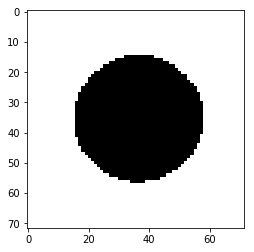

In [22]:
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

## 4.visulization of solutions

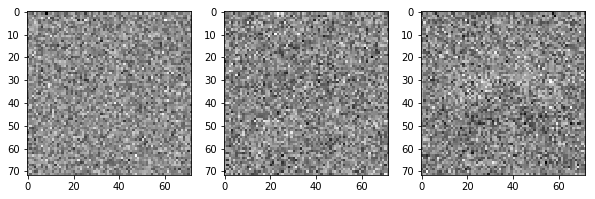

In [23]:
#visulization of model1 weights
plt.figure(figsize=(10,10))

W1=model1.get_weights()
Weight_matrix1=np.dot(W1[0],W1[2])
plt.subplot(1,3,1)
plt.imshow(Weight_matrix1[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Weight_matrix1[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Weight_matrix1[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

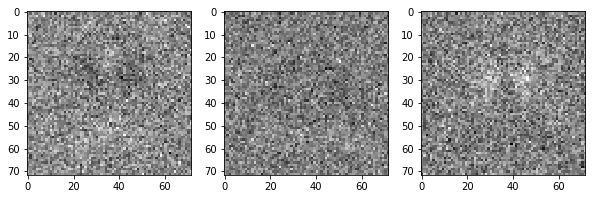

In [24]:
#visulization of model2 weights
#visulization of model1 weights
plt.figure(figsize=(10,10))

W2=model2.get_weights()
Weight_matrix2=np.dot(W2[0],W2[2])
plt.subplot(1,3,1)
plt.imshow(Weight_matrix2[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Weight_matrix2[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Weight_matrix2[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

## 5. A more difficult classification problem

In [25]:
[X_train2, Y_train2] = generate_dataset_classification(300,20,True)
Y_train2 = np_utils.to_categorical(Y_train2, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [26]:
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
X_train2=X_train2.reshape(X_train2.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
model3=Sequential()
model3.add(Convolution2D(8, (5,5), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Convolution2D(8, (5,5)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Convolution2D(8, (3,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())

model3.add(Dense(1024))
model3.add(Activation('relu'))
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(3,activation='softmax'))
model3.compile(loss='mean_squared_error',optimizer=sgd,metrics=['mse'])

model3.fit(X_train2,Y_train2,epochs=30,batch_size=30)

Epoch 1/30
300/300 [==============================] - 2s 7ms/step - loss: 0.2219 - mean_squared_error: 0.2219
Epoch 2/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2204 - mean_squared_error: 0.2204
Epoch 3/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2192 - mean_squared_error: 0.2192
Epoch 4/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2183 - mean_squared_error: 0.2183
Epoch 5/30
300/300 [==============================] - 2s 5ms/step - loss: 0.2177 - mean_squared_error: 0.2177
Epoch 6/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2163 - mean_squared_error: 0.2163
Epoch 7/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2159 - mean_squared_error: 0.2159
Epoch 8/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2142 - mean_squared_error: 0.2142
Epoch 9/30
300/300 [==============================] - 1s 5ms/step - loss: 0.2122 - mean_squared_error: 0.2122
Epoch 10/3

In [27]:
from keras.utils import np_utils
[X_test2, Y_test2] = generate_test_set_classification()
X_test2=X_test2.reshape(X_test2.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
model3.evaluate(X_test2, Y_test2)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 1s 2ms/step


[0.16112187385559082, 0.16112187385559082]

## 6.regression problem

In [73]:
[X_train3, Y_train3] = generate_dataset_regression(300, 20)
X_train3=X_train3.reshape(X_train3.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [74]:
Y_train3.shape

(300, 6)

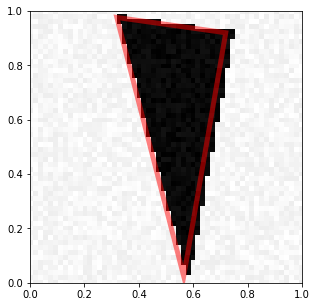

In [75]:
visualize_prediction(X_train3[0], Y_train3[0])

In [79]:
#create test set
[X_test3, Y_test3] = generate_test_set_regression()
X_test3=X_test3.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [138]:
Y_test3.shape

(300, 6)

In [78]:
X_test3.shape

(300, 5184)

In [80]:
#build model
from keras.layers.normalization import BatchNormalization
model6=Sequential()
model6.add(BatchNormalization())
model6.add(Convolution2D(8, (5,5), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Convolution2D(8, (5,5)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Convolution2D(8, (3,3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Flatten())

model6.add(Dense(1024))
model6.add(Activation('relu'))
model6.add(Dense(128))
model6.add(Activation('relu'))
model6.add(Dense(6,activation='softmax'))
model6.compile(loss='mean_squared_error',optimizer=sgd,metrics=['accuracy'])

model6.fit(X_train3,Y_train3,epochs=30,batch_size=30)

Epoch 1/30
300/300 [==============================] - 3s 8ms/step - loss: 0.1918 - acc: 0.1767
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1908 - acc: 0.2067
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1898 - acc: 0.2367
Epoch 4/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1889 - acc: 0.2467
Epoch 5/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1881 - acc: 0.2533
Epoch 6/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1872 - acc: 0.2667
Epoch 7/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1863 - acc: 0.2700
Epoch 8/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1853 - acc: 0.2600
Epoch 9/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1844 - acc: 0.2467
Epoch 10/30
300/300 [==============================] - 2s 6ms/step - loss: 0.1834 - acc: 0.2700
Epoch 11/30
300/300 [============================

In [144]:
X_test3.shape

(300, 5184)

In [145]:
Y_test3.shape

(300, 6)

In [81]:
model6.evaluate(X_test3,Y_test3)

300/300 [==============================] - 1s 3ms/step


[0.18706143856048585, 0.24333333353201547]

## 7.Image Denoising

In [82]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [83]:
def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise=np.random.randint(100)),generate_a_drawing(figsize, U, V, noise=0)]

In [84]:
def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise=np.random.randint(100)),generate_a_drawing(figsize, U, V, noise=0)]

In [85]:
def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata1 = generate_a_drawing(figsize, U, V, noise=np.random.randint(100))
    imdata2 = generate_a_drawing(figsize, U, V, noise=0)
    return [[imdata1, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]]

In [118]:
def generate_dataset_Denosing(nb_samples,free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_train= np.zeros([nb_samples,im_size])
    Y_train= np.zeros(nb_samples)
    X_test = np.zeros([nb_samples,im_size])
    Y_test = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X_train[i] = generate_a_rectangle2(free_location)[0]
            X_test[i] = generate_a_rectangle2(free_location)[1]
        elif category == 1: 
            X_train[i] = generate_a_disk2(free_location)[0]
            X_test[i] = generate_a_disk2(free_location)[1]
        else:
            [X_train[i], V1] = generate_a_triangle2(free_location)[0]
            [X_test[i], V2] = generate_a_triangle2(free_location)[1]
        Y_train[i] = category
        Y_test[i] = category
    X_train = X_train / 255
    X_test = X_test/255
    return [[X_train, Y_train],[X_test,Y_test]]

In [119]:
[X_train4,Y_train4],[X_test4,Y_test4]=generate_dataset_Denosing(300,free_location=False)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [120]:
X_train4=X_train4.reshape(X_train4.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
X_test4=X_test4.reshape(X_test4.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

In [121]:
Y_test4=np_utils.to_categorical(Y_test4,3)
Y_train4 = np_utils.to_categorical(Y_train4, 3)

In [122]:
model7=Sequential()
model7.add(Convolution2D(8, (5,5), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Convolution2D(8, (5,5)))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Convolution2D(8, (3,3)))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Flatten())

model7.add(Dense(1024))
model7.add(Activation('relu'))
model7.add(Dense(128))
model7.add(Activation('relu'))
model7.add(Dense(3,activation='softmax'))
model7.compile(loss='mean_squared_error',optimizer=sgd,metrics=['accuracy'])

model7.fit(X_train4,Y_train4,epochs=30,batch_size=30)

Epoch 1/30
300/300 [==============================] - 2s 8ms/step - loss: 0.2200 - acc: 0.4033
Epoch 2/30
300/300 [==============================] - 2s 5ms/step - loss: 0.2105 - acc: 0.5633
Epoch 3/30
300/300 [==============================] - 1s 5ms/step - loss: 0.1950 - acc: 0.6567
Epoch 4/30
300/300 [==============================] - 2s 5ms/step - loss: 0.1616 - acc: 0.6867A: 0s - loss: 0.1642 - acc: 0.685
Epoch 5/30
300/300 [==============================] - 1s 5ms/step - loss: 0.1159 - acc: 0.7533
Epoch 6/30
300/300 [==============================] - 1s 5ms/step - loss: 0.0680 - acc: 0.9000
Epoch 7/30
300/300 [==============================] - 1s 5ms/step - loss: 0.0549 - acc: 0.9100
Epoch 8/30
300/300 [==============================] - 1s 5ms/step - loss: 0.0555 - acc: 0.8967
Epoch 9/30
300/300 [==============================] - 1s 5ms/step - loss: 0.0254 - acc: 0.9533
Epoch 10/30
300/300 [==============================] - 1s 5ms/step - loss: 0.0159 - acc: 0.9767
Epoch 11/30
300/

In [123]:
model7.evaluate(X_test4,Y_test4)

300/300 [==============================] - 1s 3ms/step


[0.0007017960888333619, 1.0]

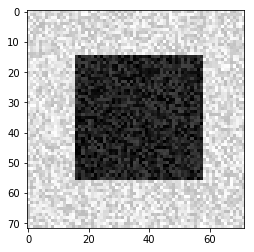

In [130]:
plt.imshow(X_train4[11].reshape(72,72),cmap='gray')

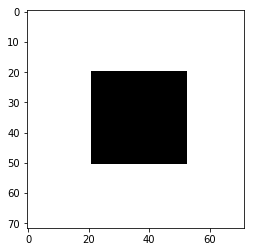

In [131]:
plt.imshow(X_test4[11].reshape(72,72),cmap='gray')